# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
import statistics

In [8]:
from sklearn.model_selection import cross_val_score

In [9]:
from scipy import stats as st

In [10]:
import warnings
warnings.filterwarnings("ignore") 

## Загрузка и подготовка данных

**Дано:** Данные геологоразведки трёх регионов:  

- id — уникальный идентификатор скважины;  
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
- product — объём запасов в скважине (тыс. баррелей).  

In [11]:
import os

pth1 = '/datasets/geo_data_0.csv'
pth2 = '/datasets/geo_data_1.csv'
pth3 = '/datasets/geo_data_2.csv'

if os.path.exists(pth1) & os.path.exists(pth1) & os.path.exists(pth1):
    data_1 = pd.read_csv(pth1)
    data_2 = pd.read_csv(pth2)
    data_3 = pd.read_csv(pth3)
else:
    print('Something is wrong')
    
data_1.head()    

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [12]:
#data_1 = pd.read_csv('/datasets/geo_data_0.csv')
#data_2 = pd.read_csv('/datasets/geo_data_1.csv')
#data_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [13]:
def data_info(data, name):
    print('   '*15)
    print('---'*15)
    print('Информация для', name)
    print('---'*15)
    display(data.head(5));
    display(data.describe());
    display(data.info());
    print('---'*15)
    print('   '*15)
    print('Пропуски в данных:')
    display(data.isna().sum())
    print('   '*15)
    print('Явные дубликаты:', data.duplicated().sum())
    print('   '*15)
    print('Дубликаты id:', data['id'].duplicated().sum())
    display(data[data['id'].isin(data['id'][data['id'].duplicated()])].sort_values(by='id'))
    print('   '*15)
    print('---'*15)
    print('   '*15)
    print('Матрица корреляции: ')
    corr = data.corr()
    display(corr.style.background_gradient(cmap='coolwarm'))
    print('---'*15)

In [14]:
data_info(data_1, name='региона 1')

                                             
---------------------------------------------
Информация для региона 1
---------------------------------------------


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------------------------------------------
                                             
Пропуски в данных:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

                                             
Явные дубликаты: 0
                                             
Дубликаты id: 10


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


                                             
---------------------------------------------
                                             
Матрица корреляции: 


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


---------------------------------------------


In [15]:
data_info(data_2, name='региона 2')

                                             
---------------------------------------------
Информация для региона 2
---------------------------------------------


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------------------------------------------
                                             
Пропуски в данных:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

                                             
Явные дубликаты: 0
                                             
Дубликаты id: 4


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


                                             
---------------------------------------------
                                             
Матрица корреляции: 


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


---------------------------------------------


In [16]:
data_info(data_3, name='региона 3')

                                             
---------------------------------------------
Информация для региона 3
---------------------------------------------


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

---------------------------------------------
                                             
Пропуски в данных:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

                                             
Явные дубликаты: 0
                                             
Дубликаты id: 4


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


                                             
---------------------------------------------
                                             
Матрица корреляции: 


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


---------------------------------------------



Во всех трех датасетах нет пропусков в данных и категориальных признаков.   
Есть повторяющиеся ```id``` скважин с разными характеристиками, при ближайшем рассмотрении в них записаны не похожие, но адекватные данные, как-будто от разных скважин.  Так как не понятно, какая запись верная, вторую дропну:

In [17]:
data_1 = data_1.drop_duplicates(subset='id', keep='last')
data_1.shape[0]

99990

In [18]:
# Для остальных двух
data_2 = data_2.drop_duplicates(subset='id', keep='first')
data_2.shape[0]
data_3 = data_3.drop_duplicates(subset='id', keep='first')
data_3.shape[0]

99996

99996

In [19]:
def visual(data, target, name, color):
    print(f'Распределение {target} для {name}')
    data[target].hist(color=color, bins=10, grid='True');

Распределение product для региона 1


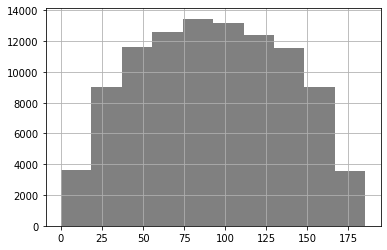

In [20]:
visual(data_1, target='product', name='региона 1', color='gray')

Распределение product для региона 2


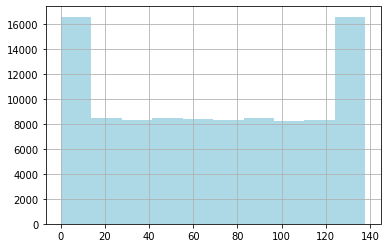

In [21]:
visual(data_2, target='product', name='региона 2', color='lightblue')

Распределение product для региона 3


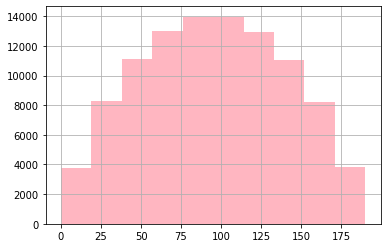

In [22]:
visual(data_3, target='product', name='региона 3', color = 'lightpink')

Так как распределение региона 2 отличается от остальных, еще распределения признаков:

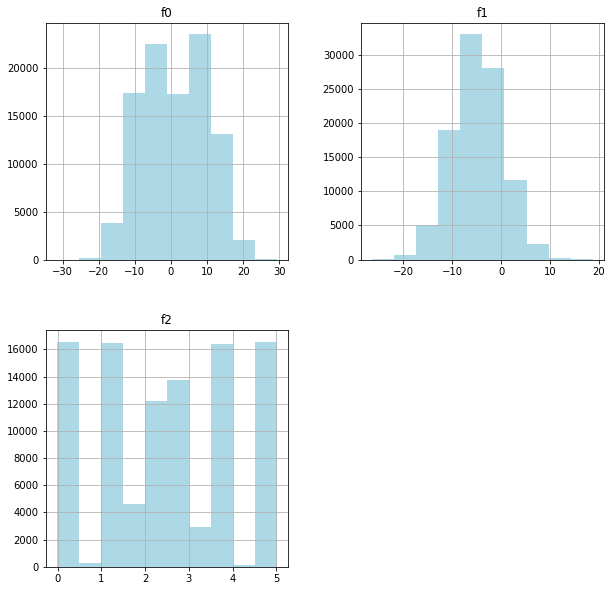

In [23]:
list2 = ['f0', 'f1', 'f2']
data_2[list2].hist(bins = 10, color = 'lightblue', figsize=(10,10));

 
При первом просмотре можно сказать, что регион 2 отличается от 1го и 3го и значениями ```f```, и их соотношением между собой.   

---

Мой target в этой задаче - стобец ```product```, ```f``` это мои features, ```id``` для обучения модели не нужен, убираю его из данных и разбиваю их на выборки:

In [24]:
data_1 = data_1.drop(['id'], axis = 1)
data_2 = data_2.drop(['id'], axis = 1)
data_3 = data_3.drop(['id'], axis = 1)
data_1.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


In [25]:
def data_split(data):
    features = data.drop(['product'], axis = 1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    return features_train, target_train, features_valid, target_valid, features, target

In [26]:
# Разобью на выборки
features_train1, target_train1, features_valid1, target_valid1, features1, target1 = data_split(data_1)
features_train1.info()
features_valid1.shape[0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74992 entries, 75170 to 86507
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      74992 non-null  float64
 1   f1      74992 non-null  float64
 2   f2      74992 non-null  float64
dtypes: float64(3)
memory usage: 2.3 MB


24998

In [27]:
# Для двух других регионов
features_train2, target_train2, features_valid2, target_valid2, features2, target2 = data_split(data_2)
features_train3, target_train3, features_valid3, target_valid3, features3, target3 = data_split(data_3)

## Обучение и проверка модели

По условию задачи для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).   
Буду обучать её:

In [28]:
def data_model(features_train, target_train, features_valid, target_valid, features, target, name):
    model = LinearRegression();
    model.fit(features_train, target_train)
    
    predictions_valid = model.predict(features_valid)
    predictions_valid = pd.Series(predictions_valid)   
    
    predictions = model.predict(features)
    predictions = pd.Series(predictions)
    
    print('Для региона', name)
    print('---'*16)
    print('RMSE:', mean_squared_error(target_valid, predictions_valid)**0.5)
    print('R2:', r2_score(target_valid, predictions_valid))    
    print('Средний запас предсказанного сырья:', predictions_valid.mean())
    
    return model, predictions, predictions_valid

In [29]:
model1, predictions1, predictions1_valid = data_model(
    features_train1, target_train1, features_valid1, target_valid1, features1, target1, name='1')

Для региона 1
------------------------------------------------
RMSE: 37.92658327086352
R2: 0.2686065064871146
Средний запас предсказанного сырья: 92.59581533981104


In [30]:
model2, predictions2, predictions2_valid = data_model(
    features_train2, target_train2, features_valid2, target_valid2, features2, target2, name='2')

Для региона 2
------------------------------------------------
RMSE: 0.892059264771703
R2: 0.9996222988190184
Средний запас предсказанного сырья: 69.17831957030432


In [31]:
model3, predictions3, predictions3_valid = data_model(
    features_train3, target_train3, features_valid3, target_valid3, features3, target3, name='3')

Для региона 3
------------------------------------------------
RMSE: 40.07585073246016
R2: 0.19556241810202346
Средний запас предсказанного сырья: 94.86572480562035


Модель для второго региона получилась единственной с хорошими показателями R2 и RMSE.

## Подготовка к расчёту прибыли

Шаги для выбора локации обычно такие:   
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Условия задачи:  
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Чтобы бурение было не убыточным в топ 200 скважинах должно быть:



In [32]:
# Для расчета достаточного количества нефти
def product_ammount(budget, barrel_price, quantity):
    return budget / (barrel_price * quantity)

budget = 10000000000
price = 450000
boreholes = 200

product_per_borehole = round(product_ammount(budget, price, boreholes), 2)
print('Достаточное среднее количество нефти для отсутствия убытков:', product_per_borehole)

Достаточное среднее количество нефти для отсутствия убытков: 111.11


In [33]:
# Выбрать 500 точек с лучшими предсказаниями:
def top_ids(model, features, count):
    predictions = model.predict(features)
    predictions = pd.Series(predictions)
    predictions_sorted = predictions.sort_values(ascending=False)[:count]
    
    return predictions_sorted

In [34]:
print('В 500 лучших точках по предсказаниям модели:')

predictions_1_500 = top_ids(model1, features1, 500)
print('1го региона в среднем:', predictions_1_500.mean())

predictions_2_500 = top_ids(model2, features2, 500)
print('2го региона в среднем:', predictions_2_500.mean())

predictions_3_500 = top_ids(model3, features1, 500)
print('3го региона в среднем:', predictions_3_500.mean())

В 500 лучших точках по предсказаниям модели:
1го региона в среднем: 158.1531108639809
2го региона в среднем: 138.89479069360306
3го региона в среднем: 147.82720397098313


**Промежуточный вывод:**  

Хотя текущие средние значения ожидаемого запаса сырья могут показывать недостаточный запас в каждом регионе, это не означает, что проект следует прекращать. Можно увидеть, что при выборе лучших точек для разработки на основе признаков скважин можно выбрать точки с количеством продукта превышающим достаточное для получения прибыли.  

Процесс бутстрапирования позволит оценить прибыль и риски работы в каждом регионе путем случайного выбора точек для анализа. Это поможет получить представление о потенциале разработки и рисках, связанных с нехваткой запаса сырья.


## Расчёт прибыли и рисков 

Нужно:  
- Выбрать скважины с максимальными значениями предсказаний. (200)  
- Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.   
- Рассчитать прибыль для полученного объёма сырья.   

---

In [35]:
# Прибыль (млрд)
def revenue(target, predictions, price, count, budget): 
    
    target = target.reset_index(drop=True)
    predictions = predictions.reset_index(drop=True)
    
    predictions_sorted = predictions.sort_values(ascending=False)[:count]    
    select = target[predictions_sorted.index]    
    return (select.sum()*price - budget) / 10000000000

In [36]:
print('Для регионов 1,2,3 прибыль в 200 лучших точках на основе предсказаний:')
revenue(target_valid1, predictions1_valid, price, boreholes, budget)
revenue(target_valid2, predictions2_valid, price, boreholes, budget)
revenue(target_valid3, predictions3_valid, price, boreholes, budget)

Для регионов 1,2,3 прибыль в 200 лучших точках на основе предсказаний:


0.299008453521183

0.2415086696681511

0.25012838532820625

Если посчитать прибыль с лучших скважин всех трех регионов, третий уже выглядит прибыльным

## Посчитайте риски и прибыль для каждого региона

Риски и прибыль для каждого региона:  
- Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.  
- Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков.   

In [42]:
# 
state = np.random.RandomState(42)
n_iterations = 1000
bootstrap_quant = 0.025
quantity = 500
holes_count = 200

def bootstrap_data(target, predictions, price, count, budget, name):
    
    values = []    
    target = target.reset_index(drop=True)
      
    for i in range(n_iterations):
        target_subsample = target.sample(n=quantity, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        
        values.append(revenue(target_subsample, predictions_subsample, price, holes_count, budget))
        

    values = pd.Series(values)
    lower = values.quantile(0.025) 
    mean = values.mean()
    confidence_interval = st.t.interval(
        alpha = 0.95, df = len(values) - 1, loc = mean, scale = values.sem() )
    values_negative = (values[values < 0].count()/values.count())*100
    
    print('Для региона', name)
    print("Средняя выручка:", mean)
    print(f'Риск убытков: {values_negative} %')
    print('95% доверительный интервал:', confidence_interval)
    
    print('---'*15)        
        
    
bootstrap_data(target_valid1, predictions1_valid, price, holes_count, budget, name='№1') 
bootstrap_data(target_valid2, predictions2_valid, price, holes_count, budget, name='№2') 
bootstrap_data(target_valid3, predictions3_valid, price, holes_count, budget, name='№3') 

Для региона №1
Средняя выручка: 0.04146500266259523
Риск убытков: 5.5 %
95% доверительный интервал: (0.03986966814996241, 0.04306033717522805)
---------------------------------------------
Для региона №2
Средняя выручка: 0.04729762735690099
Риск убытков: 1.2 %
95% доверительный интервал: (0.046033341693934735, 0.048561913019867245)
---------------------------------------------
Для региона №3
Средняя выручка: 0.033772962676639304
Риск убытков: 11.1 %
95% доверительный интервал: (0.03213149990841071, 0.0354144254448679)
---------------------------------------------


## Вывод

**Дано:** Данные геологоразведки трёх регионов;

**Задача:** Решить, в каком регионе бурить новую скважину.  

---

Задача решалась в несколько основных шагов:  

- Подготовка данных (в данном случае был удален один столбец с id);
- Разбитие данных для каждого региона на обучающую и валидационную выборки;
- Обучение трех моделей линейной регрессии для каждого региона;
- Расчёт предполагаемой прибыли из 200 лучших месторождений на основе предсказаний;
- Выбор одного из регионов как самого прибыльного для нефтедобычи.

---

**Ход работы:**  

В ходе работы были получены три модели, однако хороших показателей r2 и rmse удалось достичь только у одной из них - в регионе 2.  
После выбора лучших 200 месторождений, среднее ожидаемое количество в них нефти получилось следующим:

|регион|количество нефти|ожидаемая прибыль|риск убытков|
|---|---|---|--|
|№1|157.76 тыс|0.04 млн|5.5%|
|№2|138.90 тыс|0.04 млн|1.2%|
|№3|147.24 тыс|0.03 млн|11.1%|

**Вывод:** Единственным регионом, прошедним проверку на пригодность (удовлетворяющим условию "риск убытков менее 2.5%"), в ходе работы стал 2ой регион